## Parte Computacional Punto 3
### Coordenadas parabólicas

Autores: Juan Fernando Riascos y Thomas Martinod

En este `.ipynb` se presenta brevemente la segunda parte del tercer numeral de la segunda tarea de Mecánica Clásica... Vamos a resolver numéricamente las ecuaciones de Lagrange para diferentes condiciones iniciales y analizar los resultados.

Inicialmente, vamos a usar `sympy` para definir las variables simbólicamente, luego aplicaremos `lambdify` y así obtener funciones numéricas de las expresiones sibólicas,  y finalmente usaremos `scipy.integrate.odeint` para resolver las ecuaciones de Euler Lagrange (EL).

In [276]:
# Importe de librerías
import sympy as smp
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

from sympy.physics.mechanics import *
init_vprinting(pretty_print=True)

# Definimos las variables simbólicas
t, m = smp.symbols('t, m')

# Definimos tau y sigma como funciones del tiempo
tau, sig = smp.symbols('tau, sigma', cls=smp.Function)
tau, sig = tau(t), sig(t)
tau

In [277]:
# Definimos las derivadas de las coordenadas
dtau = smp.diff(tau, t)
dsig = smp.diff(sig, t)

d2tau = smp.diff(dtau, t)
d2sig = smp.diff(dsig, t)

d2sig

In [278]:
# Definimos el Lagrangiano
L = smp.Rational(1,2) * m * (tau**2 + sig**2) * (dtau**2 + dsig**2)

Recordemos que las ecuaciones EL son:

$$    \frac{\partial L}{\partial u_i} - \frac{d}{dt}\left(\frac{\partial L}{\partial \dot{u}_i}\right) = 0 $$

o también se escriben:

$$L_{u_i} - \frac{d}{dt} L_{\dot{u}_i} = 0$$

Comencemos con $u_i = \tau$.

In [279]:
L_tau = smp.diff(L, tau)
L_tau

In [280]:
L_dtau = smp.diff(L, dtau)
L_dtau

In [281]:
dL_dtau = smp.diff(L_dtau, t)
dL_dtau

In [282]:
EL1 = smp.Eq(L_tau - dL_dtau, 0)
EL1

De modo que esta última es la primera ecuación EL. Ahora obtengamos la segunda ecuación de Euler Lagrange con $u_i = \sigma$:

In [283]:
L_sig = smp.diff(L, sig)

In [284]:
L_dsig = smp.diff(L, dsig)

In [285]:
dL_dsig = smp.diff(L_dsig, t)

In [286]:
EL2 = smp.Eq(L_sig - dL_dsig, 0)
EL2

Dadas estas dos ecuaciones diferenciales de segundo orden, despejemos $\ddot{\tau}$ y $\ddot{\sigma}$:

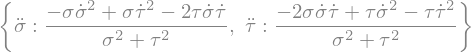

In [287]:
sln = smp.solve([EL1, EL2], (d2tau, d2sig))
sln

Inicialmente, necesitamos cuatro EDOs de primer orden a partir de las dos EDOs de segundo orden que obtuvimos. Para ello definimos las variables auxiliares $z_\tau$ y $z_\sigma$ como:

$$ \frac{d\tau}{dt} =: z_\tau$$
$$ \frac{d\sigma}{dt} =: z_\sigma$$


Obteniendo entonces el sistema de cuatro EDOs de primer orden:

$$ \frac{d\tau}{dt} = z_\tau$$
$$\frac{d z_{\tau}}{dt} = \frac{- 2 \sigma z_{\sigma} z_{\tau}+ \tau (z_{\sigma})^{2} - \tau (z_{\tau})^2}{\sigma^{2} + \tau^{2}}$$
$$ \frac{d\sigma}{dt} = z_\sigma$$
$$ \frac{dz_{\sigma}}{dt} = \frac{-\sigma (z_{\sigma})^2 + \sigma (z_{\tau})^2 - 2\tau z_{\sigma} z_\tau}{\sigma^2 + \tau^2} $$






Necesitamos convertir las anteriores funciones simbólicas a numéricas. Para ello usamos `smp.lambdify`.




In [288]:
dztaudt_f = smp.lambdify((t,tau, sig, dtau, dsig), sln[d2tau])
dzsigdt_f = smp.lambdify((t,tau, sig, dtau, dsig), sln[d2sig])
dtaudt_f = smp.lambdify(dtau, dtau)
dsigdt_f = smp.lambdify(dtau, dtau)

Ahora, debemos definir $\vec{S} = (\tau, z_\tau, \sigma, z_\sigma)$. Si vamos a usar un solver en python, necesitamos crear una función que tome el vector $\vec{S}$ y el tiempo $t$ and y retorne $d\vec{S}/dt$. En otras palabras, debemos definir $d\vec{S}/dt (\vec{S}, t)$.

Así, nuestro sistema de EDOs viene completamente especificado por $d\vec{S}/dt$ y depende solo de $\vec{S}$ y $t$.

In [289]:
def dSdt(S, t):
    ttau, zztau, ssig, zzsig = S
    return [
        dtaudt_f(zztau),
        dztaudt_f(t, ttau, ssig, zztau, zzsig),
        dsigdt_f(zzsig),
        dzsigdt_f(t, ttau, ssig, zztau, zzsig),
    ]

Finalmente, antes de resolver el sistema de EDOS, necesitamos especificar las condiciones iniciales del sistema. Comencemos tomando el vector de condiciones iniciales como:

$$\text{ics} = \begin{pmatrix} \tau(0) \\ \dot{\tau}(0) \\ \sigma(0) \\ \dot{\sigma}(0) \end{pmatrix} = \begin{pmatrix} 1 \\ -2 \\ 5 \\ -2 \end{pmatrix}$$

In [290]:
ics = [1, -2, 5, -2]

Se solucionan ahora las ecuaciones EL usando odeint para $t \in [0, 40]$

In [291]:
t_v = np.linspace(0, 40, 1001)
ans = odeint(dSdt, y0=ics, t=t_v)

Y extraemos las componentes de $\vec{S}$:

In [292]:
tau_v = ans.T[0]
dtau_v = ans.T[1]
sig_v = ans.T[2]
dsig_v = ans.T[3]

tau_v

array([  1.        ,   0.91874305,   0.83486404, ..., -29.53512892,
       -29.55030764, -29.56547857])

Primero veamos una gráfica que muestre la evolución temporal de ambas coordenadas $\tau$ y $\sigma$ en el tiempo.

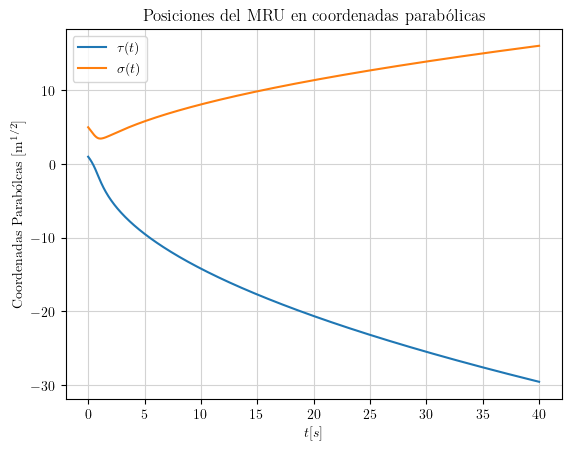

In [293]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"]
})

plt.figure()

plt.plot(t_v, tau_v, label=r'$\tau(t)$')
plt.plot(t_v, sig_v, label=r'$\sigma(t)$')


plt.xlabel(r'$t [s]$')
plt.ylabel(r'Coordenadas Parabólcas $[$m$^{1/2}]$')
plt.title(r'Posiciones del MRU en coordenadas parabólicas')
plt.legend()

plt.grid(True, color='lightgray')
plt.show()


Ahora, veamos la evolución de las derivadas de estas coordenadas en el tiempo:

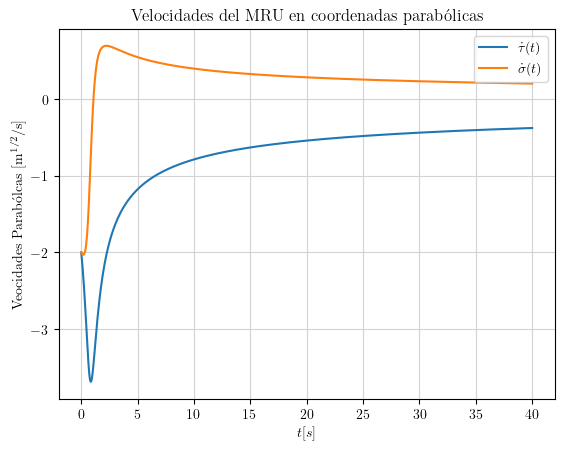

In [294]:
plt.figure()

plt.plot(t_v, dtau_v, label=r'$\dot{\tau}(t)$')
plt.plot(t_v, dsig_v, label=r'$\dot{\sigma}(t)$')


plt.xlabel(r'$t [s]$')
plt.ylabel(r'Veocidades Parabólcas  $[$m$^{1/2}/$s$]$')
plt.title(r'Velocidades del MRU en coordenadas parabólicas ')
plt.legend()

plt.grid(True, color='lightgray')
plt.show()


Nota: Nos referimos a $\dot{\tau}$ y $\dot{\sigma}$ como velocidades parabóicas a pesar de que no tengan unidades de velocidad. Veamos las proyecciones del espacio de fases sobre cada coordenada y su momento conjugago ($m=1$).

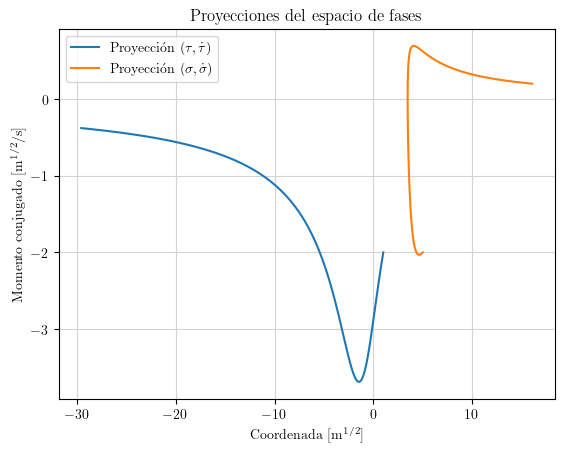

In [295]:
plt.figure()

plt.plot(tau_v, dtau_v, label=r'Proyección $(\tau, \dot{\tau})$')
plt.plot(sig_v, dsig_v, label=r'Proyección $(\sigma, \dot{\sigma})$')


plt.xlabel(r'Coordenada $[$m$^{1/2}]$')
plt.ylabel(r'Momento conjugado $[$m$^{1/2}/$s$]$')
plt.title(r'Proyecciones del espacio de fases')
plt.legend()

plt.grid(True, color='lightgray')
plt.show()


Ahora, para verificar que las ecuaciones EL deducidas tienen como solución un MRU, tomemos los vectores solución de `scipy.integrate.odeint` y hagamos la conversión a coordenadas cartesianas.

In [296]:
# Función para obtener las coordenadas y velocidades cartesianas a partir de las parabólicas
def getCartesian(ttau, dttau, ssig, dssig):
    return [ttau * ssig,
            (ttau**2 + ssig**2)/2,
            ssig * dttau + ttau * dssig,
            ttau * dttau - ssig * dssig]

x_v, y_v, dx_v, dy_v = getCartesian(tau_v, dtau_v, sig_v, dsig_v)

Inicialmente grafiquemos las coordenadas $x$ y $y$:

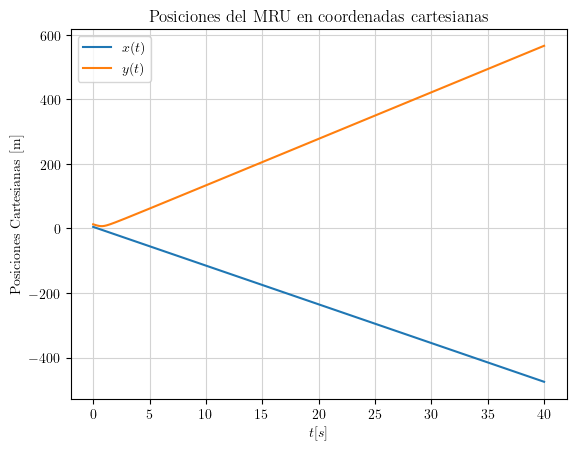

In [297]:
plt.figure()

plt.plot(t_v, x_v, label=r'$x(t)$')
plt.plot(t_v, y_v, label=r'$y(t)$')


plt.xlabel(r'$t [s]$')
plt.ylabel(r'Posiciones Cartesianas [m]')
plt.title(r'Posiciones del MRU en coordenadas cartesianas')
plt.legend()

plt.grid(True, color='lightgray')
plt.show()


Ahora grafiquemos las velocidades $\dot{x}$ y $\dot{y}$:

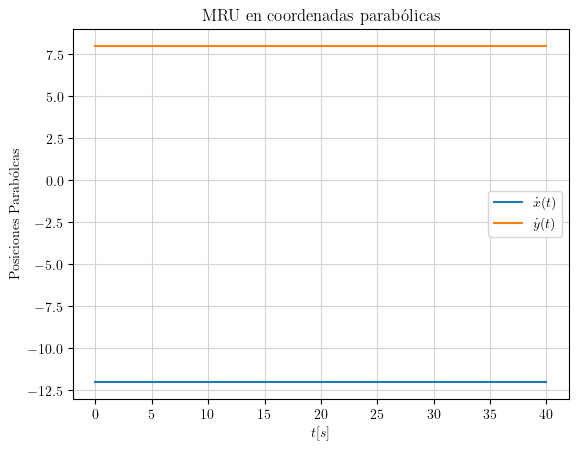

In [298]:
plt.figure()

plt.plot(t_v, dx_v, label=r'$\dot{x}(t)$')
plt.plot(t_v, dy_v, label=r'$\dot{y}(t)$')


plt.xlabel(r'$t [s]$')
plt.ylabel(r'Posiciones Parabólcas')
plt.title(r'MRU en coordenadas parabólicas')
plt.legend()

plt.grid(True, color='lightgray')
plt.show()


Claramente estas dos últimas gráficas nos dan, ahora si, una intuición sobre el movimiento que tiene nuestra masa unitaria. Es fácil ver que ambas velocidades cartesianas son constantes, y que las coordenadas $x$ y $y$ ambas siguen la ecuación de una recta, por lo que la partícula libre sigue una trayectoria recta en el epacio, siguiendo la primera ley de Newton.

¿Por qué se ven tan extrañas las gráficas en coordenadas parabólicas? Porque hicimos mal la elección del sistema de referencia. En realidad, no hubo nada erroneo en nuesstros cálculos, solo que surgen fuerzas ficticias por la elección de este sistema.

Ahora bien, repetiremos otra vez este proceso para unas nuevas condiciones iniciales, pero de nuevo esperando los mismos resultados... gráficas exóticas representando un MRU en coordenadas parabólicas

Tomemos:

$$\text{ics} = \begin{pmatrix} \tau(0) \\ \dot{\tau}(0) \\ \sigma(0) \\ \dot{\sigma}(0) \end{pmatrix} = \begin{pmatrix} 6 \\ 0 \\ 0 \\ -12 \end{pmatrix}$$

In [299]:
ics = [6, 0, 0, -12]
ans = odeint(dSdt, y0=ics, t=t_v)

tau_v = ans.T[0]
dtau_v = ans.T[1]
sig_v = ans.T[2]
dsig_v = ans.T[3]

La gráfica que muestra la evolución temporal de ambas coordenadas $\tau$ y $\sigma$ en el tiempo es:

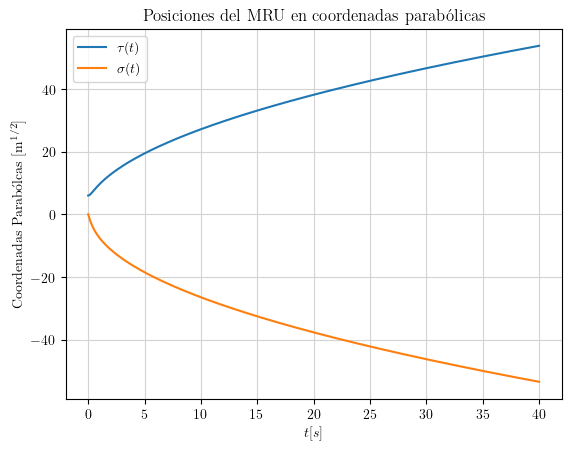

In [300]:
plt.figure()

plt.plot(t_v, tau_v, label=r'$\tau(t)$')
plt.plot(t_v, sig_v, label=r'$\sigma(t)$')


plt.xlabel(r'$t [s]$')
plt.ylabel(r'Coordenadas Parabólcas $[$m$^{1/2}]$')
plt.title(r'Posiciones del MRU en coordenadas parabólicas')
plt.legend()

plt.grid(True, color='lightgray')
plt.show()


Las velocidades parabólicas son:

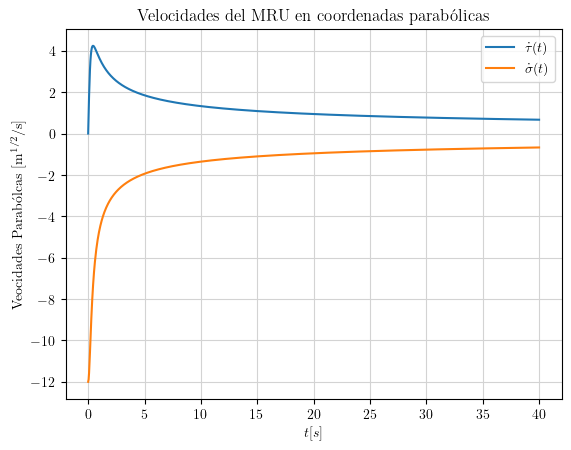

In [301]:
plt.figure()

plt.plot(t_v, dtau_v, label=r'$\dot{\tau}(t)$')
plt.plot(t_v, dsig_v, label=r'$\dot{\sigma}(t)$')


plt.xlabel(r'$t [s]$')
plt.ylabel(r'Veocidades Parabólcas  $[$m$^{1/2}/$s$]$')
plt.title(r'Velocidades del MRU en coordenadas parabólicas ')
plt.legend()

plt.grid(True, color='lightgray')
plt.show()

Y lass proyecciones del espacio de fases:

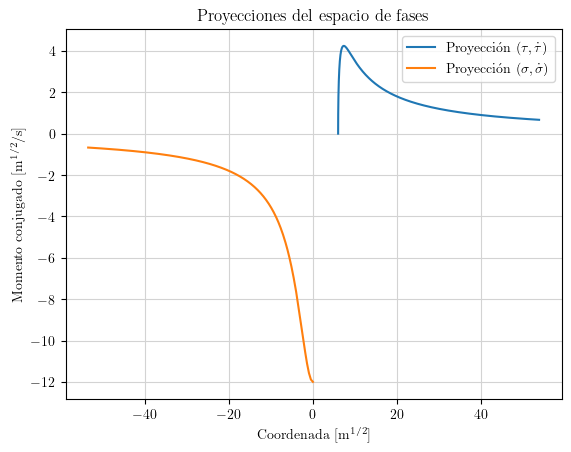

In [302]:
plt.figure()

plt.plot(tau_v, dtau_v, label=r'Proyección $(\tau, \dot{\tau})$')
plt.plot(sig_v, dsig_v, label=r'Proyección $(\sigma, \dot{\sigma})$')


plt.xlabel(r'Coordenada $[$m$^{1/2}]$')
plt.ylabel(r'Momento conjugado $[$m$^{1/2}/$s$]$')
plt.title(r'Proyecciones del espacio de fases')
plt.legend()

plt.grid(True, color='lightgray')
plt.show()

Ahora volvamos al mundo cartesiano. Las velocidades $\dot{x}$ y $\dot{y}$ en el tiempo se enseñan a continuación:

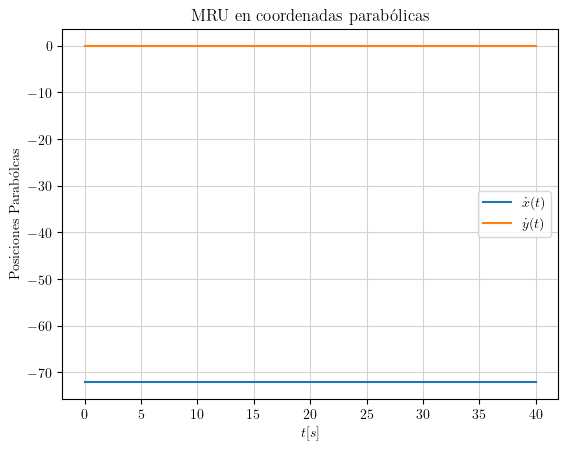

In [305]:
plt.figure()

plt.plot(t_v, dx_v, label=r'$\dot{x}(t)$')
plt.plot(t_v, dy_v, label=r'$\dot{y}(t)$')


plt.xlabel(r'$t [s]$')
plt.ylabel(r'Posiciones Parabólcas')
plt.title(r'MRU en coordenadas parabólicas')
plt.legend()

plt.grid(True, color='lightgray')
plt.show()


Por lo que tenemos un MRU en una dimensión :)